# Documentación del Dataset – Clasificación de Flexiones por Técnica

## 1. Introducción al problema

La correcta ejecución de los ejercicios de fuerza —especialmente los ejercicios de autocarga como las flexiones— es fundamental para evitar lesiones y garantizar un entrenamiento eficaz. Sin embargo, muchas personas sin experiencia previa desconocen si están realizando el movimiento con una técnica adecuada.

Este proyecto aborda el siguiente problema:

**¿Es posible clasificar vídeos de flexiones en función de si la técnica de ejecución es buena o mala?**

El objetivo final es desarrollar un sistema inteligente capaz de analizar vídeos de personas realizando flexiones y determinar si la postura corporal es correcta. Esto tendría aplicaciones directas en sistemas de asistencia deportiva, plataformas de entrenamiento remoto y herramientas educativas para principiantes.

---

## 2. Obtención y procesamiento del conjunto de datos

### 2.1. Origen de los datos

Hemos obtenido el dataset con los vídeos de la página: https://www.kaggle.com/datasets/mohamadashrafsalama/pushup/data.  
En ellos, varias personas realizan flexiones de dos tipos:

- **Flexiones con técnica correcta**  
- **Flexiones con técnica incorrecta**  
  (por ejemplo: codos demasiado abiertos, cadera hundida, rango de movimiento insuficiente, etc.)

Cada vídeo se etiqueta manualmente según la calidad de ejecución de la flexión.

### 2.2. Preprocesamiento con MediaPipe Pose

Para evitar trabajar directamente con frames completos (lo que implicaría un coste computacional elevado), se aplica un preprocesamiento basado en **MediaPipe Pose**, una librería de visión por computador que identifica automáticamente 33 puntos clave del cuerpo (*landmarks*) en cada frame del vídeo.

Para cada frame se extraen:

- Coordenada **x**
- Coordenada **y**

de cada punto clave relevante.

Esto produce un array NumPy por vídeo con la forma (num_frames, 66), donde 66 corresponde a **33 puntos × 2 coordenadas**.

### 2.3. Cálculo de ángulos articulares

A partir de los landmarks se calcula, para cada frame, un conjunto de **ángulos articulares determinantes**, como por ejemplo:

- Ángulo del codo (izquierdo y derecho)
- Ángulo de la rodilla (izquierdo y derecho)
- Ángulo de la cadera respecto al tronco
- Ángulos relacionados con la posición del torso

Esto genera el dataset final, con cada frame representado por un array de $n_{\text{frames}} \times 8$
, donde cada fila contiene los **8 ángulos** calculados para un frame.

Este formato es mucho más manejable y captura la postura corporal de forma eficaz para el posterior modelado.

---

## 3. Tarea y uso previsto de los datos

El dataset se utilizará para entrenar un modelo de *deep learning* secuencial basado en **redes LSTM**, capaz de analizar la evolución temporal de los ángulos articulares durante la ejecución del ejercicio.

El objetivo de la red es clasificar cada secuencia (cada vídeo) como:

- **Flexión bien ejecutada**
- **Flexión mal ejecutada**

La tarea es, por tanto, un problema de **clasificación binaria sobre datos temporales**.



# Librerías

In [1]:
import sys
sys.path.append("../src")
from utils import extract_xy_sequence, extract_frame_from_video, draw_landmarks_on_frame

import cv2
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Extracción de los puntos clave de los vídeos
Utilizamos la librería Media Pipe para la extracción de las coordenadas de los puntos clave del cuerpo en el vídeo. En el fichero utils.py, tenemos algunas funciones necesarias para la extracción de los landmarks. 

El propósito de este proyecto no se centra en la predicción de las coordenadas de los landmarks, sino en analizar como la posición de éstos evoluciona en el vídeo para determinar si la flexión está bien hecha o no. 

In [2]:
# Ejemplo de uso
data_path = "../data"
correct_push_ups_path = os.path.join(data_path, "Correct sequence")
wrong_push_ups_path = os.path.join(data_path, "Wrong sequence")
example_video_path = os.path.join(correct_push_ups_path, "Copy of push up 1.mp4")
seq = extract_xy_sequence(example_video_path)
print("Forma de la secuencia de landmarks", seq.shape)    # → (num_frames, 33, 2)
print("Tipo de datos de la secuencia de landmarks", type(seq))          # array con las coordenadas (x,y) de los 33 landmarks por frame


I0000 00:00:1763231805.115580   54321 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M1 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1763231805.210715   54622 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1763231805.219413   54630 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/opt/miniconda3/envs/exml-py310/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Forma de la secuencia de landmarks (61, 66)
Tipo de datos de la secuencia de landmarks <class 'numpy.ndarray'>


(-0.5, 639.5, 359.5, -0.5)

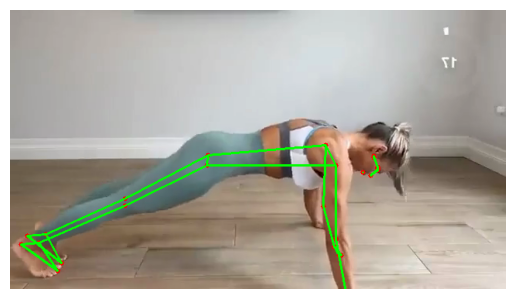

In [3]:
import matplotlib.pyplot as plt
import os

# Ejemplo de uso (comentado):
# frame = cv2.imread('ruta_a_imagen.jpg')  # BGR

# Extraemos un frame del vídeo
path_video = os.path.join(data_path, "Correct sequence", "Copy of push up 1.mp4")
frame10 = extract_frame_from_video(path_video, frame_idx=10)

# Nos quedamos con los landmarks del frame 10
lm = seq[10]  # si seq tiene shape (num_frames, 66) o (num_frames, 33, 2)

# Dibujamos los landmarks sobre el frame
draw_landmarks_on_frame(frame10, lm)
plt.imshow(cv2.cvtColor(frame10, cv2.COLOR_BGR2RGB))
plt.axis('off')

frame10 = extract_frame_from_video(path_video, frame_idx=10)

# Nos quedamos con los landmarks del frame 10
lm = seq[10]  # si seq tiene shape (num_frames, 66) o (num_frames, 33, 2)

# Dibujamos los landmarks sobre el frame
draw_landmarks_on_frame(frame10, lm)
plt.imshow(cv2.cvtColor(frame10, cv2.COLOR_BGR2RGB))
plt.axis('off')


In [4]:
# Probamos a añadir padding a la secuencia de ejemplo
PADDING_LENGTH = 150  # longitud máxima de secuencia (frames)

padding_needed = PADDING_LENGTH - seq.shape[0]
padding_array = np.zeros((padding_needed, 66))

seq_padded = np.vstack((seq, padding_array))
print(seq_padded.shape)  # → (150, 66)

(150, 66)


In [5]:
# Extraemos todos los landmarks de los vídeos de flexiones
correct_push_ups_videos = os.listdir(correct_push_ups_path) 
wrong_push_ups_videos = os.listdir(wrong_push_ups_path)

# Listas donde almacenaremos las secuencias de landmarks de cada vídeo
correct_push_ups_data = []
wrong_push_ups_data = []

for video_file in correct_push_ups_videos:
    video_path =  os.path.join(correct_push_ups_path, video_file)
    seq = extract_xy_sequence(video_path)

    correct_push_ups_data.append(seq)

for video_file in wrong_push_ups_videos:
    video_path =  os.path.join(wrong_push_ups_path, video_file)
    seq = extract_xy_sequence(video_path)

    wrong_push_ups_data.append(seq)

lengths_correct = np.array(list(map(lambda x: x.shape, correct_push_ups_data)))
lengths_wrong = np.array(list(map(lambda x: x.shape, wrong_push_ups_data)))

I0000 00:00:1763231811.978585   54321 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M1 Pro
W0000 00:00:1763231812.051920   54738 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1763231812.058350   54738 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1763231813.371608   54321 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M1 Pro
W0000 00:00:1763231813.440287   54767 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1763231813.446640   54767 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1763231814.799747   54321 gl

I0000 00:00:1763231964.366447   54321 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M1 Pro
W0000 00:00:1763231964.436765   57495 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1763231964.443159   57495 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1763231966.248416   54321 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M1 Pro
W0000 00:00:1763231966.317783   57533 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1763231966.324296   57541 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1763231968.005824   54321 gl

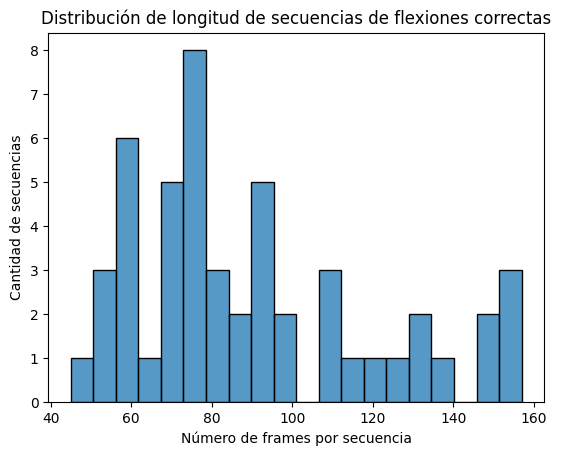

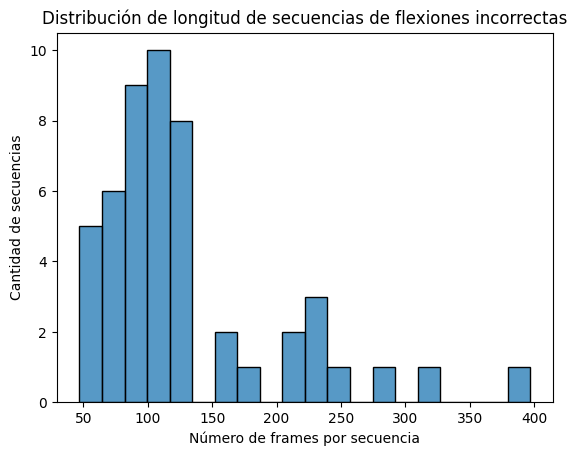

In [6]:
# Graficamos la distribución de número de frames por secuencia
import matplotlib.pyplot as plt 
import seaborn as sns

sns.histplot([l[0] for l in lengths_correct], bins=20)
plt.xlabel("Número de frames por secuencia")
plt.ylabel("Cantidad de secuencias")
plt.title("Distribución de longitud de secuencias de flexiones correctas")
plt.show()

sns.histplot([l[0] for l in lengths_wrong], bins=20)
plt.xlabel("Número de frames por secuencia")
plt.ylabel("Cantidad de secuencias")
plt.title("Distribución de longitud de secuencias de flexiones incorrectas")
plt.show()


Podemos observar que la gran mayoría de vídeos no tiene más de 200 frames. Por ende, sería conveniente añadirle un padding de 0s a los que tenga menos frames y truncar aquellos que superen esa cantidad.

In [7]:
import os
import numpy as np

def load_landmark_sequences_from_folder(folder_path, padding_length=200):
    """
    Procesa todos los videos de una carpeta y devuelve un array
    de secuencias de landmarks con shape (n_videos, padding_length, 66).

    Args:
        folder_path (str): ruta a la carpeta con vídeos
        padding_length (int): nº máximo de frames para pad/recorte

    Returns:
        np.ndarray: array final con shape (n_videos, padding_length, 66)
    """

    videos = os.listdir(folder_path)
    sequences = []

    for video_name in videos:
        video_path = os.path.join(folder_path, video_name)

        # Extraemos coordenadas (num_frames, 33, 2)
        seq = extract_xy_sequence(video_path)

        # Aplanamos por frame → (num_frames, 66)
        seq = seq.reshape(seq.shape[0], -1)

        # === Padding o recorte ===
        n_frames = seq.shape[0]

        if n_frames < padding_length:
            # Padding con ceros
            padding_needed = padding_length - n_frames
            padding = np.zeros((padding_needed, 66))
            seq_padded = np.vstack((seq, padding))

        elif n_frames > padding_length:
            # Recorte
            seq_padded = seq[:padding_length, :]

        else:
            seq_padded = seq

        # Añadimos al dataset
        sequences.append(seq_padded)

    # Convertimos lista → numpy array 3D
    return np.array(sequences)


In [8]:
# Procesamos todos los landmarks de los vídeos de flexiones en ambas carpetas
PADDING_LENGTH = 160  # longitud máxima de secuencia (frames)

correct_push_ups_data = load_landmark_sequences_from_folder(correct_push_ups_path, padding_length=PADDING_LENGTH)
wrong_push_ups_data   = load_landmark_sequences_from_folder(wrong_push_ups_path,   padding_length=PADDING_LENGTH)


print("Forma de los landmarks arrays de los vídeos de flexiones correctas:", correct_push_ups_data.shape)  # (n_videos, 160, 66)
print("Forma de los landmarks arrays de los vídeos de flexiones incorrectas:", wrong_push_ups_data.shape)  # (n_videos, 160, 66)


I0000 00:00:1763232009.258401   54321 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M1 Pro
W0000 00:00:1763232009.327363   58313 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1763232009.334026   58313 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/opt/miniconda3/envs/exml-py310/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
I0000 00:00:1763232010.644270   54321 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M1 Pro
W0000 00:00:1763232010.711648   58340 inference_feedback_manager.cc:1

I0000 00:00:1763232160.403011   54321 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M1 Pro
W0000 00:00:1763232160.468678   60938 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1763232160.474715   60938 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1763232162.275499   54321 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M1 Pro
W0000 00:00:1763232162.344160   60961 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1763232162.350457   60961 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1763232164.039089   54321 gl

Forma de los landmarks arrays de los vídeos de flexiones correctas: (50, 160, 66)
Forma de los landmarks arrays de los vídeos de flexiones incorrectas: (50, 160, 66)


In [9]:
# Almacenamos en discos los arrays procesados
np.save("../data/processed/correct_push_ups_landmarks.npy", correct_push_ups_data)
np.save("../data/processed/wrong_push_ups_landmarks.npy",   wrong_push_ups_data)

## Análisis exploratorio de datos

In [10]:
import numpy as np 
import os

# Indicamos la ruta a los datos
PATH = "../Data/processed"

# Cargamos los datos
# Contienen etiquetas con los puntos clave del cuerpo durante las flexiones
# Los arrays tienen forma (num_ejemplos, num_frames, num_keypoints)
# num_keypoints -> 1er_punto_clave_x, 1er_punto_clave_y, 2º_punto_clave_x, 2º_punto_clave_y, ...

correct_push_ups = np.load(os.path.join(PATH, 'correct_push_ups_landmarks.npy'))
wrong_push_ups = np.load(os.path.join(PATH, 'wrong_push_ups_landmarks.npy'))

print("Correct push-ups shape:", correct_push_ups.shape)
print("Incorrect push-ups shape:", wrong_push_ups.shape)

Correct push-ups shape: (50, 160, 66)
Incorrect push-ups shape: (50, 160, 66)


Vemos que ambos conjuntos de datos tienen el mismo número de videos, cada vídeo tiene el mismo número de frames y cada frame tiene el mismo número de landmarks.

**¿Cuál es el rango de valores que toman las coordenadas?**

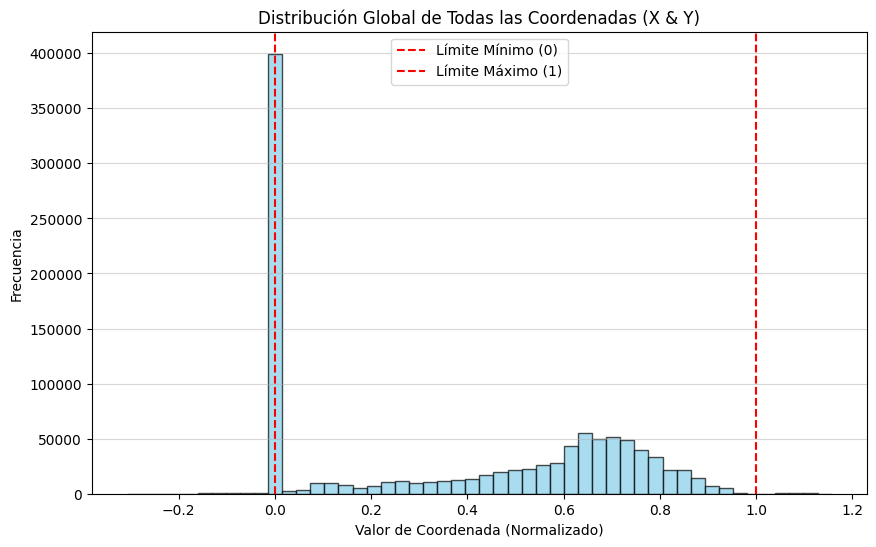

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Asumiendo que 'data_array' es un numpy array de forma (50, 160, 66)
# data_array = np.load('tu_archivo.npy') 

# 1. Aplana todos los datos de coordenadas
all_coords = np.concatenate((correct_push_ups, wrong_push_ups)).flatten()

# 2. Configura y graficar el histograma
plt.figure(figsize=(10, 6))
plt.hist(all_coords, bins=50, color='skyblue', edgecolor='black', alpha=0.7)

plt.title('Distribución Global de Todas las Coordenadas (X & Y)')
plt.xlabel('Valor de Coordenada (Normalizado)')
plt.ylabel('Frecuencia')
plt.grid(axis='y', alpha=0.5)
plt.axvline(x=0, color='r', linestyle='--', label='Límite Mínimo (0)')
plt.axvline(x=1, color='r', linestyle='--', label='Límite Máximo (1)')
plt.legend()
plt.show()

La herramienta de visión artificial MediaPipe Pose predice la posición de 33 puntos clave del cuerpo (x, y), tomando como origen la esquina inferior izquierda del frame. Cada vídeo tenía una longitud distinta originalmente. Sin embargo, anteriormente añadimos paddings de 0s para que todas las secuencias tuvieran la misma longitud, lo que explica la gran cantidad de ceros observada en el histograma. En la arquitectura de red indicaremos que estos 0s son de padding con una capa Masking.

Por otro lado, algunos valores de las coordenadas superan 1 o son menores a 0. Esto ocurre cuando ciertos puntos clave quedan fuera del plano de la imagen. Estos datos pueden considerarse válidos, ya que únicamente representan posiciones fuera del marco visual y, siempre que mantengan coherencia geográfica con el resto del cuerpo, no deberían afectar negativamente al modelo de clasificación.




**¿Cuál es la proporción de relleno (padding) en cada vídeo?**

Veámos la distribución de esta medida en el dataset.

In [12]:
video0 = correct_push_ups[0]  # primer vídeo
#print(video0.shape)  # (160, 66)
#print(video0)        # imprime todos los frames y landmarks del vídeo 0, cada fila indica los landmarks de un frame 

frame0_video0 = correct_push_ups[0, 0]  # primer frame del primer vídeo
#print(frame0_video0.shape)  # (66,)
#print(frame0_video0)        # imprime los 66 landmarks de ese frame (coincide con la primera fila del print anterior)

landmark0_frame0_video0 = correct_push_ups[0, 0, 0]  # primer landmark
#print(landmark0_frame0_video0)  # valor del landmark 

Media de padding por secuencia: 37.63%
Máximo padding: 71.88%
Mínimo padding: 0.00%


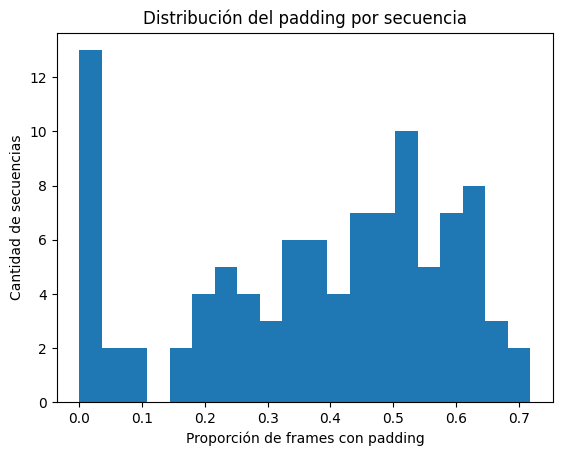

In [13]:
# Calculamos la proporción de frames vacíos (rellenos con ceros) por secuencia
padding_ratios = []

data = np.vstack((correct_push_ups, wrong_push_ups))
for seq in data:
    # Un frame está vacío si todos sus landmarks son 0 
    empty_frames = np.sum(np.all(seq == 0, axis=1)) # suma cada fila que es todo 0
    ratio = empty_frames / seq.shape[0]
    padding_ratios.append(ratio)

# Estadísticas del padding
print(f"Media de padding por secuencia: {np.mean(padding_ratios):.2%}")
print(f"Máximo padding: {np.max(padding_ratios):.2%}")
print(f"Mínimo padding: {np.min(padding_ratios):.2%}")

# Distribución visual
plt.hist(padding_ratios, bins=20)
plt.xlabel("Proporción de frames con padding")
plt.ylabel("Cantidad de secuencias")
plt.title("Distribución del padding por secuencia")
plt.show()

El porcentaje obtenido es un poco alto, 37.63% pero esto se debe a que en los videos incorrectos, algunos (9 videos) superaban los 200 frames, llegando hasta los 400, por lo que esto incrementó el numero óptimo de frames por vídeo al calcular $L_{opt}$.

Vamos a comprobar si los landmarks están normalizados

In [14]:
longitudes_combinadas = np.vstack((correct_push_ups, wrong_push_ups)).reshape(-1, correct_push_ups.shape[2]) 
# Con el -1 del reshape combinamos el número de videos y el número de frames, obteniendo una lista donde cada fila es un frame individual de cualquier video (100*160 numero de filas).
# 'correct_push_ups.shape[2]' lo que hace es mantener el número de landmarks (66) como el número de columnas, es decir, cada fila tiene los 66 landmarks de ese frame.

min_val = np.min(longitudes_combinadas)
max_val = np.max(longitudes_combinadas)

print(f"Valor mínimo de coordenadas: {min_val:.4f}")
print(f"Valor máximo de coordenadas: {max_val:.4f}")

Valor mínimo de coordenadas: -0.3072
Valor máximo de coordenadas: 1.1568


Vamos a normalizar los landmarks.

In [ ]:
rango = max_val - min_val

# Aplicamos la fórmula de Re-normalización
longitudes_combinadas_escaladas = (longitudes_combinadas - min_val) / rango

correct_push_ups_escaladas = (correct_push_ups - min_val) / rango
incorrect_push_ups_escaladas = (wrong_push_ups - min_val) / rango

In [15]:
correct_push_ups_escaladas = correct_push_ups
incorrect_push_ups_escaladas = wrong_push_ups

Podemos ver que en el caso de los vídeos correctos (los únicos que hemos seleccionado), los landmarks se agrupan por zonas más o menos diferenciadas, lo cual es indicativo de que los landmarks están ordenados. Es un poco complicado diferenciar las partes del cuerpo, por lo que vamos a ver la distribución espacial de los landmarks uniendo los puntos para poder visualizar la pose promedio de cada clase.

In [ ]:
# Definimos las conexiones del esqueleto (pares de índices de landmarks) 
# Esto es específico para un modelo de 33 landmarks (como MediaPipe Pose), cada tupla (start_idx, end_idx) conecta dos landmarks.
# Si buscamos información sobre las conexiones de MediaPipe Pose: https://ai.google.dev/edge/mediapipe/solutions/vision/pose_landmarker?hl=es-419#models, vemos que cada punto corresponde a la siguiente parte del cuerpo:
CONNECTIONS = [
    # Cabeza
    (0, 1), (1, 2), (2, 3), (3, 7), 
    (0, 4), (4, 5), (5, 6), (6, 8),
    (9, 10), 

    # Torso y Hombros
    (11, 12),  # Hombros
    (11, 23),  # Hombro Izquierdo a Cadera Izquierda
    (12, 24),  # Hombro Derecho a Cadera Derecha
    (23, 24),  # Caderas

    # Brazo Izquierdo
    (11, 13), (13, 15), 
    # Mano Izquierda
    (15, 17), (15, 19), (15, 21), 

    # Brazo Derecho
    (12, 14), (14, 16), 
    # Mano Derecha
    (16, 18), (16, 20), (16, 22), 

    # Pierna Izquierda
    (23, 25), (25, 27), 
    # Pie Izquierdo
    (27, 29), (29, 31), 

    # Pierna Derecha
    (24, 26), (26, 28), 
    # Pie Derecho
    (28, 30), (30, 32) 
]

def plot_pose_media(data_correctas, data_incorrectas, title="Comparación de Pose Media"):
    """
    data_correctas: array (N, F, dims)
    data_incorrectas: array (N, F, dims)
    dims = 66 (x,y), 99 (x,y,z), 132 (x,y,z,visibility)
    
    Dibuja el esqueleto promedio para ambas clases.
    """
    
    def compute_pose_media(dataset):
        frames = dataset.reshape(-1, dataset.shape[-1])  # Aplanamos (n_videos*frames, 66)
        dims_per_point = frames.shape[-1] // 33 # Calculamos cuántas dimensiones tiene cada punto (x,y) o (x,y,z). En nuestro caso 66/33=2 (x,y)
        mean_pose = np.mean(frames, axis=0) # Calculamos el promedio de cada columna a lo largo de todos los frames. Esto genera un vector con (33 * dims_per_point) valores
        return mean_pose.reshape(33, dims_per_point)[:, :2] # Reorganizamos ese vector en forma de (33 puntos, dims_per_point) -> Solo x,y
    
    pose_correcta = compute_pose_media(data_correctas)
    pose_incorrecta = compute_pose_media(data_incorrectas)
    
    # ---- GRÁFICO ----
    plt.figure(figsize=(8, 8))
    plt.title(title)
    plt.xlabel("X normalizada")
    plt.ylabel("Y normalizada")
    plt.gca().invert_yaxis()

    # Puntos
    plt.scatter(pose_correcta[:, 0], pose_correcta[:, 1],
                color="blue", label="Correcta", s=80, alpha=0.8)
    plt.scatter(pose_incorrecta[:, 0], pose_incorrecta[:, 1],
                color="red", label="Incorrecta", s=80, alpha=0.8)

    # Conexiones
    for a, b in CONNECTIONS:
        x1, y1 = pose_correcta[a]
        x2, y2 = pose_correcta[b]
        plt.plot([x1, x2], [y1, y2],
                 color="blue", alpha=0.6, linewidth=2)

        x1, y1 = pose_incorrecta[a]
        x2, y2 = pose_incorrecta[b]
        plt.plot([x1, x2], [y1, y2],
                 color="red", alpha=0.6, linewidth=2, linestyle="--")

    plt.legend()
    plt.grid(True)
    plt.show()

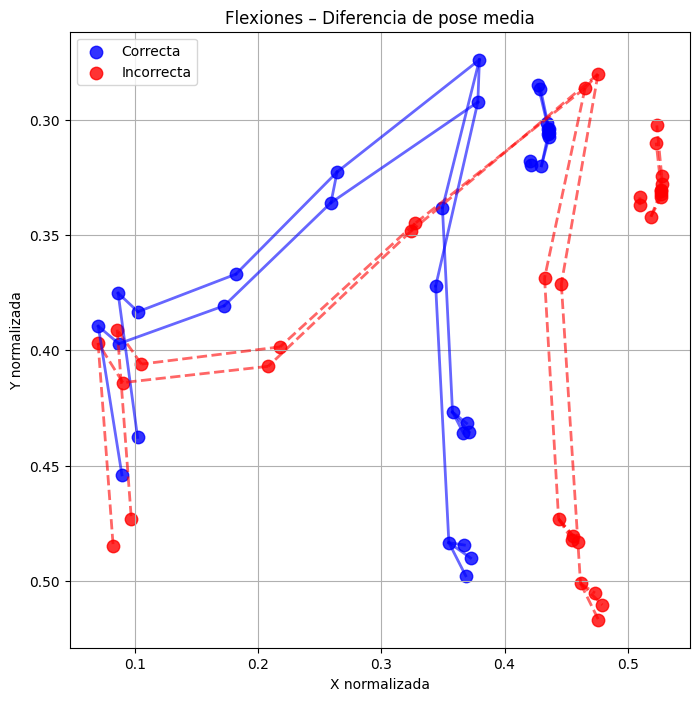

In [36]:
plot_pose_media(correct_push_ups_escaladas,
                incorrect_push_ups_escaladas,
                title="Flexiones – Diferencia de pose media")

Se aprecian perfectamente las partes del cuerpo en ambas clases y se ve cómo en la clase de flexiones incorrectas, las rodillas y la cabeza están más abajo de lo normal.


### Estadísticas descriptivas

Media, desviación estándar y rango por landmark (x, y).

Comparación entre clases: ¿la media de la posición del pecho o codo difiere entre clases?

In [ ]:
# Definimos los nombres de los landmarks 
LANDMARK_NAMES = [
    'nose', 'left eye (inner)', 'left eye', 'left eye (outer)', 'right eye (inner)', 'right eye', 'right eye (outer)', 
    'left ear', 'right ear', 'mouth (left)', 'mouth (right)', 'left shoulder', 'right shoulder', 'left elbow', 
    'right elbow', 'left wrist', 'right wrist', 'left pinky', 'right pinky', 'left index', 'right index', 
    'left thumb', 'right thumb', 'left hip', 'right hip', 'left knee', 'right knee', 'left ankle', 
    'right ankle', 'left heel', 'right heel', 'left foot index', 'right foot index'
]

def compute_landmark_statistics(dataset, label=None):
    """
    dataset: array (N_videos, N_frames, dims)
    dims = 33*2, 33*3, o 33*4

    Returns DataFrame con estadísticas descriptivas de cada coordenada.
    """

    n_points = 33
    dims_per_point = dataset.shape[-1] // n_points

    # Generamos nombres de coordenadas dinámicamente
    coord_letters = ["X", "Y", "Z", "visibility"][:dims_per_point]
    coord_names = [f"{lm} ({c})" for lm in LANDMARK_NAMES for c in coord_letters]

    # Aplanamos los datos para que cada fila sea un frame único. (N_total_frames, dims)
    frames = dataset.reshape(-1, dataset.shape[-1]) 

    # Calculamos las estadísticas a lo largo del eje 0 (todos los frames)
    stats = {
        "Coordenada": coord_names,
        "Media (μ)": np.mean(frames, axis=0),
        "Desviación Estándar (σ)": np.std(frames, axis=0),
        "Máximo": np.max(frames, axis=0),
        "Mínimo": np.min(frames, axis=0)
    }
    stats["Rango (Max - Min)"] = stats["Máximo"] - stats["Mínimo"]

    df = pd.DataFrame(stats)

    if label is not None: 
        df.insert(0, "Clase", label)

    return df

In [ ]:
# Análisis de la clase Correcta
df_correctas = compute_landmark_statistics(correct_push_ups_escaladas, label='Correcta')

# Análisis de la clase Incorrecta
df_incorrectas = compute_landmark_statistics(incorrect_push_ups_escaladas, label='Incorrecta')

# Análisis del conjunto combinado (para variabilidad global)
longitudes_combinadas_escaladas = np.vstack((correct_push_ups_escaladas.reshape(-1, NUM_COORDS), 
                                            incorrect_push_ups_escaladas.reshape(-1, NUM_COORDS)))

df_combinado = compute_landmark_statistics(longitudes_combinadas_escaladas, label='Global')

# Podemos usar pandas.concat para ver todas las estadísticas juntas
df_final = pd.concat([df_correctas, df_incorrectas, df_combinado], ignore_index=True)
print(df_final.to_markdown(index=False)) # Hacemos que la tabla se vea bien en la terminal

| Clase      | Coordenada            |   Media (μ) |   Desviación Estándar (σ) |   Máximo |     Mínimo |   Rango (Max - Min) |
|:-----------|:----------------------|------------:|--------------------------:|---------:|-----------:|--------------------:|
| Correcta   | nose (X)              |   0.429937  |                 0.381752  | 0.940509 |  0         |            0.940509 |
| Correcta   | nose (Y)              |   0.319891  |                 0.305343  | 0.916196 |  0         |            0.916196 |
| Correcta   | left eye (inner) (X)  |   0.436051  |                 0.386959  | 0.942475 |  0         |            0.942475 |
| Correcta   | left eye (inner) (Y)  |   0.30733   |                 0.296211  | 0.91437  |  0         |            0.91437  |
| Correcta   | left eye (X)          |   0.436021  |                 0.386906  | 0.941455 |  0         |            0.941455 |
| Correcta   | left eye (Y)          |   0.30569   |                 0.294787  | 0.91245  |  0         |       

Con estos resultados podemos ver la ubicación media de diversas partes del cuerpo, por ejemplo la nariz está a una altura de 0.533876 del eje X, mientras que el pie derecho está a una altura de 0.268688 respecto al eje X. Las desviaciones nos sirven para ver cuanto varía la posición del landmark respecto a su media, y como podemos observar, obtenemos valores normales teniendo en cuenta que el movimiento es una flexión. Si nos vamos a partes más fijas a lo largo de una flexión, como pueden ser los pies que permanecen inmóviles, obtenemos desviaciones mucho más bajas en el eje X, como 0.0780976 en el pie izquierdo y 0.0738948 en el derecho.

### Ángulos que forman los landmarks
Unas características muy importantes a la hora de determinar si una flexión se realiza correctamente son los ángulos articulares (por ejemplo, doblar las rodillas es síntoma de que la técnica no es buena).

In [ ]:
KEYPOINTS = {
    'nariz': 0,
    'hombro_I': 11, 'hombro_D': 12,
    'codo_I': 13,   'codo_D': 14,
    'muñeca_I': 15, 'muñeca_D': 16,
    'cadera_I': 23, 'cadera_D': 24,
    'rodilla_I': 25, 'rodilla_D': 26,
    'tobillo_I': 27, 'tobillo_D': 28
}

def get_coords(landmarks, idx):
    """
    Devuelve las coordenadas del landmark idx.
    Funciona con landmarks en formato:
       2D → [x,y]
       3D → [x,y,z]
       4D → [x,y,z,visibility]
    """
    dims = landmarks.shape[-1] // 33
    start = idx * dims
    end = start + dims
    return landmarks[start:end]

def calculate_angle(p1, p2_vertex, p3):
    """
    Calcula el ángulo en B dado A-B-C.
    Robusto frente:
    - vectores cero
    - NaNs
    - rango del coseno
    """

    if np.any(np.isnan([p1, p2_vertex, p3])):
        return 0.0
    
    # Calculamos los vectores
    vector_ba = p1 - p2_vertex
    vector_bc = p3 - p2_vertex

    norm_ba = np.linalg.norm(vector_ba)
    norm_bc = np.linalg.norm(vector_bc)

    # Manejamos el caso de vectores de longitud cero
    if norm_ba < 1e-6 or norm_bc < 1e-6:
        return 0.0

    # Calculamos el coseno del ángulo usando la fórmula del producto punto. 
    cos_theta = np.dot(vector_ba, vector_bc) / (norm_ba * norm_bc + 1e-6) # Se añade 1e-6 para evitar división por cero en caso de vectores muy pequeños
    
    # Nos aseguramos que el valor esté en el rango [-1, 1] para evitar errores numéricos al pasar cos_theta a arccos
    cos_theta = np.clip(cos_theta, -1.0, 1.0)

    return np.degrees(np.arccos(cos_theta))

def get_key_joint_angles(frame):
    """
    frame: vector 1D con landmarks (66, 99 o 132 valores)
    
    Devuelve un dict con los ángulos claves.
    """
    angles = {}

    # Para abreviar
    get = lambda name: get_coords(frame, KEYPOINTS[name])

    # Ángulos de codo
    angles['codo_I'] = calculate_angle(get('hombro_I'), get('codo_I'), get('muñeca_I'))
    angles['codo_D'] = calculate_angle(get('hombro_D'), get('codo_D'), get('muñeca_D'))

    # Alineación del tronco
    angles['cadera_I_tronco'] = calculate_angle(get('hombro_I'), get('cadera_I'), get('rodilla_I'))
    angles['cadera_D_tronco'] = calculate_angle(get('hombro_D'), get('cadera_D'), get('rodilla_D'))

    # Rodillas (sentadillas)
    angles['rodilla_I'] = calculate_angle(get('cadera_I'), get('rodilla_I'), get('tobillo_I'))
    angles['rodilla_D'] = calculate_angle(get('cadera_D'), get('rodilla_D'), get('tobillo_D'))

    # Cadera (sentadillas) – reutilizamos el cálculo
    angles['cadera_I_squat'] = angles['cadera_I_tronco']
    angles['cadera_D_squat'] = angles['cadera_D_tronco']

    # Tronco usando la nariz
    angles['tronco_nariz_I'] = calculate_angle(get('nariz'), get('hombro_I'), get('cadera_I'))
    angles['tronco_nariz_D'] = calculate_angle(get('nariz'), get('hombro_D'), get('cadera_D'))

    return angles

def landmarks_to_angle_df(dataset, add_video_id=False):
    """
    dataset: array con forma (n_videos, n_frames, dims)
    dims = 66, 99 o 132 según tengas 33*2, 33*3, 33*4 valores.

    Devuelve:
        DataFrame con 8 columnas de ángulos.
        (optional) columnas video_id y frame_id.
    """

    n_videos, n_frames, dims = dataset.shape

    rows = []

    # Recorremos todos los vídeos y frames
    for video_idx in range(n_videos):
        for frame_idx in range(n_frames):

            # Extraemos el vector de landmarks 1D para el frame actual.
            frame = dataset[video_idx, frame_idx]

            # Si la suma de todas las coordenadas es cero, se asume que es un frame de 'padding' (relleno) y se omite
            if frame.sum() == 0:
                continue

            # Llamamos a la función ya definida para calcular los ángulos clave
            angles = get_key_joint_angles(frame)

            # Añadimos IDs si se solicita. Por trazabilidad.
            if add_video_id:
                angles['video_id'] = video_idx
                angles['frame_id'] = frame_idx

            # Añadimos el diccionario de ángulos (e indices) a la lista de filas
            rows.append(angles)

    # Convertimos la lista de diccionarios (rows) en un DataFrame de Pandas donde cada diccionario se convierte en una fila.
    return pd.DataFrame(rows)

In [ ]:
angles_correct = landmarks_to_angle_df(correct_push_ups_escaladas, add_video_id=True)
angles_wrong = landmarks_to_angle_df(incorrect_push_ups_escaladas, add_video_id=True)

In [ ]:
# Añadimos etiquetas
angles_correct["Clase"] = "Correcto"
angles_wrong["Clase"] = "Incorrecto"

# Unimos las dos tablas
df_combined = pd.concat([angles_correct, angles_wrong], ignore_index=True)

In [46]:
print(df_combined.shape) # tiene 9979 filas y no 16000 (100*160) porque se han eliminado los frames vacíos
df_combined.head()

(9979, 13)


,codo_I,codo_D,cadera_I_tronco,cadera_D_tronco,rodilla_I,rodilla_D,cadera_I_squat,cadera_D_squat,tronco_nariz_I,tronco_nariz_D,video_id,frame_id,Clase
0,169.856945,158.475117,171.933641,171.953429,160.084373,153.434990,171.933641,171.953429,147.187452,125.866953,0,0,Correcto
1,167.329337,158.152149,174.614427,173.050983,161.929687,152.255270,174.614427,173.050983,141.832322,126.580677,0,1,Correcto
2,165.792876,154.966171,176.964783,173.615889,162.712927,151.711751,176.964783,173.615889,131.781995,125.353584,0,2,Correcto
3,162.783938,150.143773,179.023442,172.641034,164.115419,150.745304,179.023442,172.641034,121.319094,123.246623,0,3,Correcto
4,159.050138,144.189542,178.363899,170.232730,165.299472,151.285607,178.363899,170.232730,116.336243,122.201948,0,4,Correcto


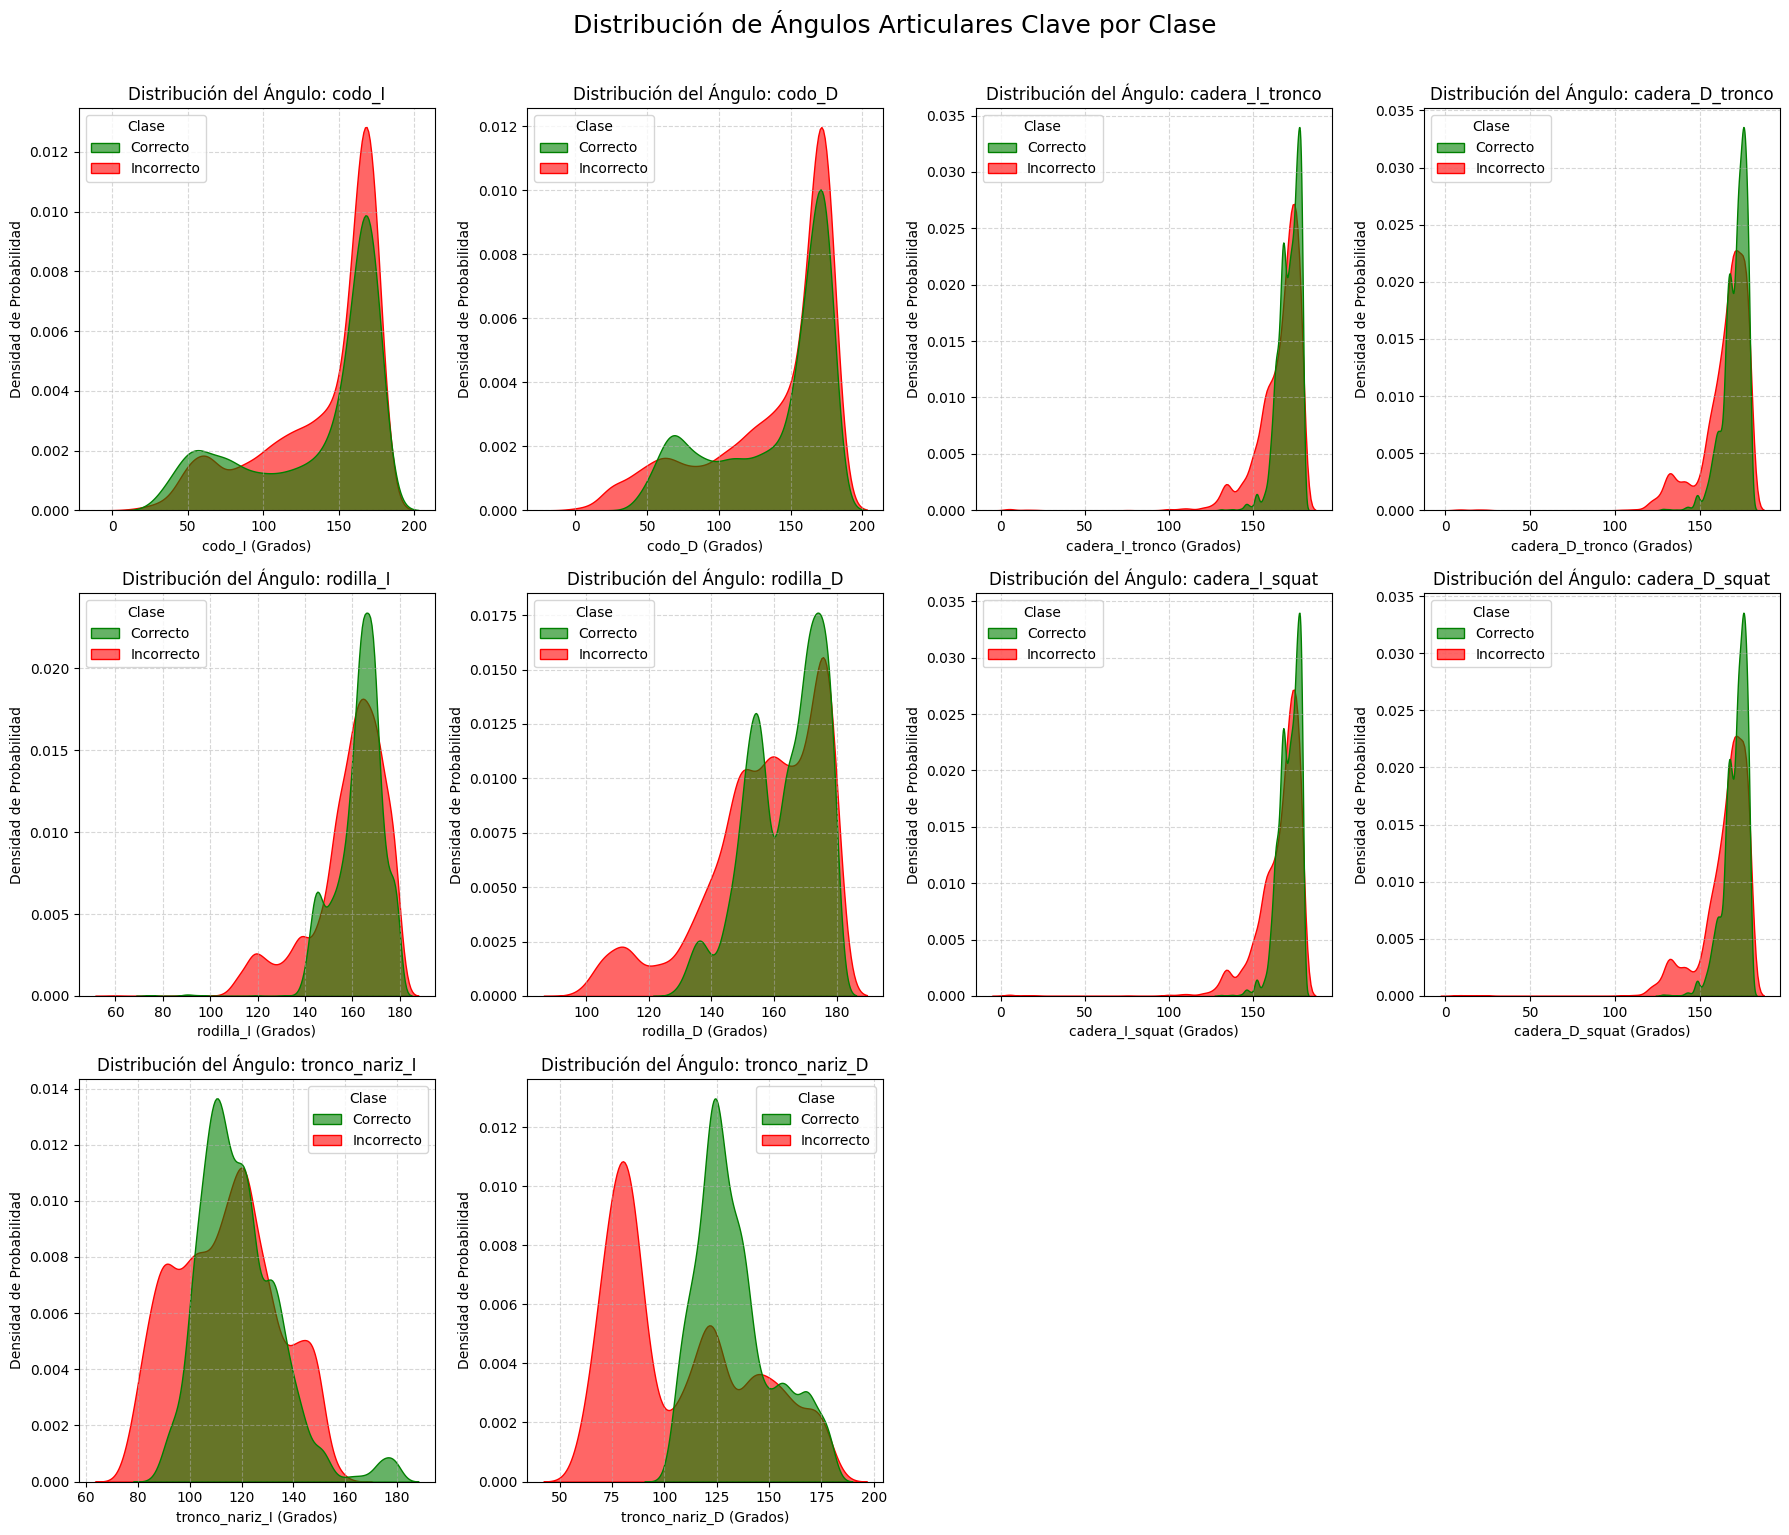

In [44]:
# Definimos las columnas de ángulos a graficar excluyendo las columnas que no son ángulos ('Clase', 'video_id', 'frame_id')
columns_to_exclude = ['Clase', 'video_id', 'frame_id']
all_angle_columns = [col for col in df_combined.columns if col not in columns_to_exclude]
num_plots = len(all_angle_columns)

# Configuramos el lienzo 
cols = 4
rows = int(np.ceil(num_plots / cols))

fig, axes = plt.subplots(
    nrows=rows, 
    ncols=min(num_plots, cols), 
    figsize=(18, 5 * rows)
)
# Aplanamos los ejes para facilitar el indexado
axes = axes.flatten() 

# Título general
fig.suptitle('Distribución de Ángulos Articulares Clave por Clase', 
             fontsize=18, 
             y=1.02)

# Bucle para generar los gráficos de densidad KDE
for i, angle_col in enumerate(all_angle_columns):
    
    # usamos seaborn.kdeplot para comparar las distribuciones 
    sns.kdeplot(
        data=df_combined,
        x=angle_col,
        hue='Clase', # Diferencia las clases por color
        fill=True, # Rellena el área bajo la curva
        palette={'Correcto': 'green', 'Incorrecto': 'red'},
        alpha=0.6,
        ax=axes[i]
    )
    
    # Configuración de los ejes y el título
    axes[i].set_title(f'Distribución del Ángulo: {angle_col}')
    axes[i].set_xlabel(f'{angle_col} (Grados)')
    axes[i].set_ylabel('Densidad de Probabilidad')
    axes[i].grid(True, linestyle='--', alpha=0.5)

# Limpiamos subplots vacíos (solo tenemos 10 gráficos y el grid es de 12)
for empty_idx in range(num_plots, rows * cols):
    if empty_idx < len(axes): # Pequeña comprobación
        fig.delaxes(axes[empty_idx])

# Ajustamos diseño y mostramos
plt.tight_layout(rect=[0, 0, 1, 1.01])
plt.show()

Parece que las distribuciones de los ángulos articulares de cada clase son muy similares. Si nos fijamos en las distribuciones de los ángulos de las rodillas, por debajo de 150º encontramos más frames de posturas incorrectas que correctas (cuanto menor sea el ángulo más se dobla la articulación).

### Reducción de dimensionalidad

Aplicamos PCA o t-SNE sobre los vectores medios de cada vídeo → ver si las clases se separan visualmente.

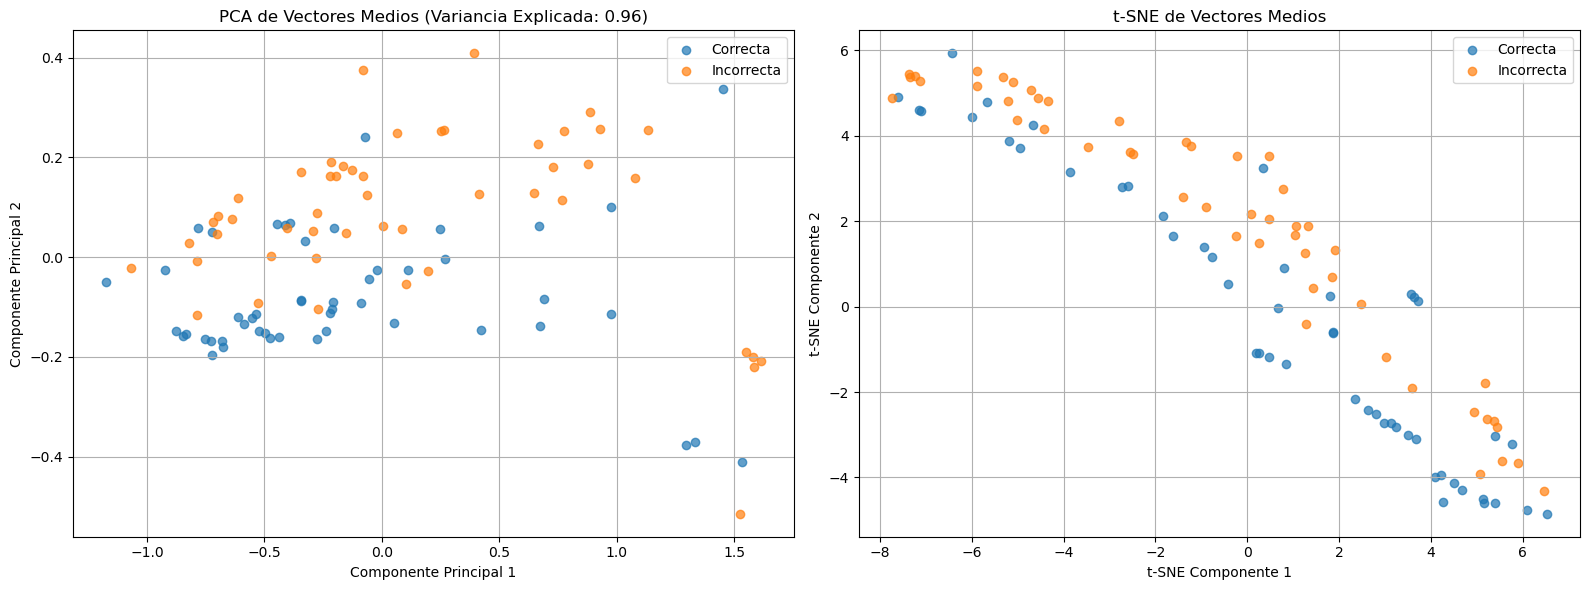

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Calculamos el vector medio (pose promedio) por vídeo 
mean_vectors_correct = np.mean(correct_push_ups_escaladas, axis=1) # Media a lo largo del eje 1 (frames). Esto reduce la forma (Videos, Frames, Coordenadas) a (Videos, Coordenadas)
mean_vectors_incorrect = np.mean(incorrect_push_ups_escaladas, axis=1)

# Combinamos los vectores medios en una sola matriz (X_mean) y creamos etiquetas (y)
X_mean = np.vstack((mean_vectors_correct, mean_vectors_incorrect))
y = np.array(['Correcta'] * mean_vectors_correct.shape[0] + ['Incorrecta'] * mean_vectors_incorrect.shape[0])

# Aplicamos PCA 
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_mean)
explained_variance = pca.explained_variance_ratio_.sum()

# Aplicamos t-SNE 
tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto') 
X_tsne = tsne.fit_transform(X_mean)

# Generamos gráficos
plt.figure(figsize=(16, 6))

# Subplot 1: PCA
plt.subplot(1, 2, 1)
for label in np.unique(y):
    subset = X_pca[y == label]
    plt.scatter(subset[:, 0], subset[:, 1], label=label, alpha=0.7)

plt.title(f'PCA de Vectores Medios (Variancia Explicada: {explained_variance:.2f})')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.grid(True)

# Subplot 2: t-SNE
plt.subplot(1, 2, 2)
for label in np.unique(y):
    subset = X_tsne[y == label]
    plt.scatter(subset[:, 0], subset[:, 1], label=label, alpha=0.7)

plt.title('t-SNE de Vectores Medios')
plt.xlabel('t-SNE Componente 1')
plt.ylabel('t-SNE Componente 2')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('visualizacion_separacion_clases.png')
plt.show()

En el PCA, a pesar de que ambos conjuntos no estén completamente separados (se mezclan en el centro) podemos ver cómo los puntos naranjas (flexiones incorrectas) se agrupan en la parte superior derecha (valores más altos), mientras que los puntos que hacen referencia a las flexiones bien hechas, se agrupan en la parte media-inferior izquierda (valores más bajos) 

El gráfico de t-SNE confirma la separación encontrada por PCA. t-SNE muestra una clara estructura lineal donde los puntos de una clase siguen una línea que está por encima o por debajo de los puntos de la otra clase, con una separación mínima. La mayoría de los puntos incorrectos (naranja) están desplazados ligeramente por encima y a la izquierda de los puntos correctos (azul). Esto sugiere que la diferencia entre las clases es ciertamente consistente.  
Concluyendo, mediante t-SNE observamos que en el espacio de alta dimensión (los 66 landmarks), los videos de una clase están íntimamente relacionados entre sí, y que la distancia entre un video correcto y un video incorrecto es grande.